# Image Segmentation - MMC2025

First, import the necessary packages and set the plotting backend, which controls how images are displayed.

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import histogram
import skimage.filters as filters
import skimage.measure as measure
import skimage.morphology as morphology
from PIL import Image

%matplotlib inline

Load the image and plot it, as previously demonstrated today.

In [83]:
image = np.asarray(Image.open('JEOL HAADF Image.tiff'))

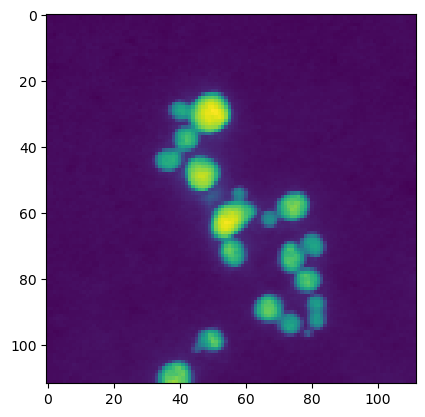

In [88]:
plt.imshow(image)

A histogram of the loaded image shows the pixel values of background and particles in this case. The aim is to find a threshold value that separates particles from background as accurately as possible.

In [89]:
hist, hist_centers = histogram(image)

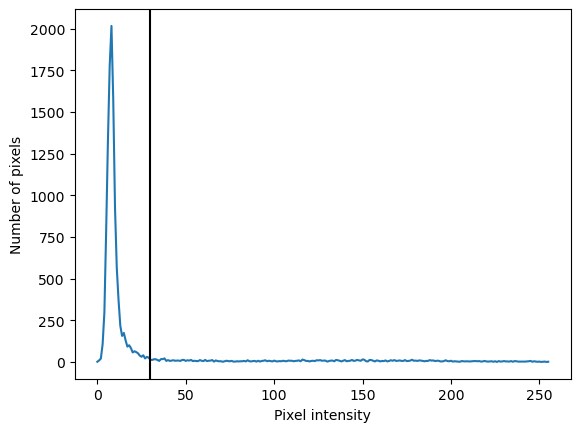

In [90]:
plt.figure()
plt.plot(hist)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.axvline(x = 30, color = 'k', label = 'axvline - full height')
plt.show()

A threshold value of 30 looks okay on the histogram, so let's try that.

In [91]:
markers = np.zeros_like(image)
markers[image_uint8 > 30] = 1

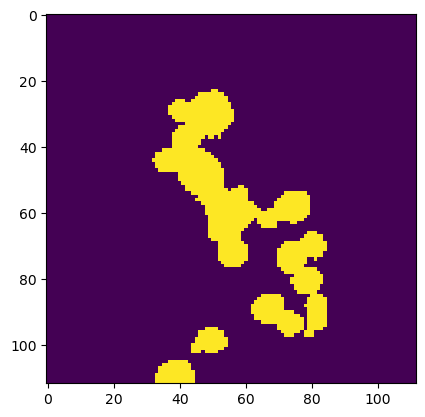

In [92]:
plt.figure()
plt.imshow(markers)

Thresholding with a value of 30 oversegmented the particles (included some background). Let's try a value of 50 instead.

In [93]:
markers = np.zeros_like(image)
markers[image > 50] = 1

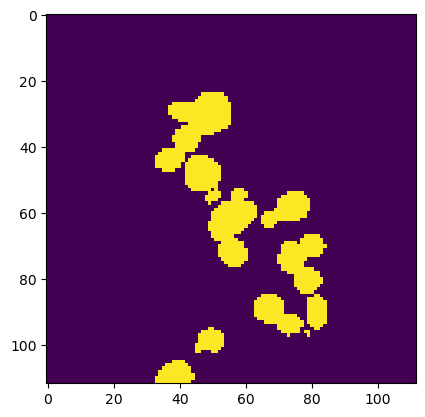

In [94]:
plt.figure()
plt.imshow(markers)

Manually searching for a threshold value is not the quickest or most repeatable method for segmentation. Instead, it's possible to use an automated method to find a threshold value. First, let's try an Otsu threshold.

In [95]:
thresh = filters.threshold_otsu(image)

In [96]:
print(thresh)

84


In [97]:
markers = np.zeros_like(image)
markers[image > thresh] = 1

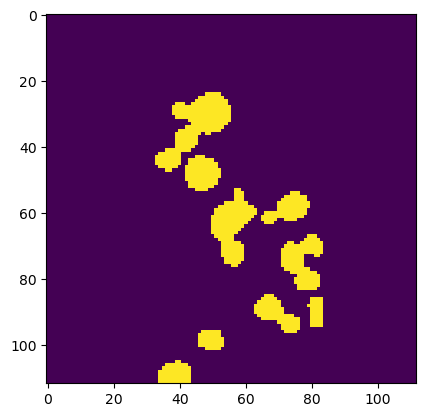

In [98]:
plt.figure()
plt.imshow(markers)

The Otsu theshold performs okay, although might not be the best in this particular case. There are many thresholding algorithms in scikit-image and it's possible to try all of them using the following function.

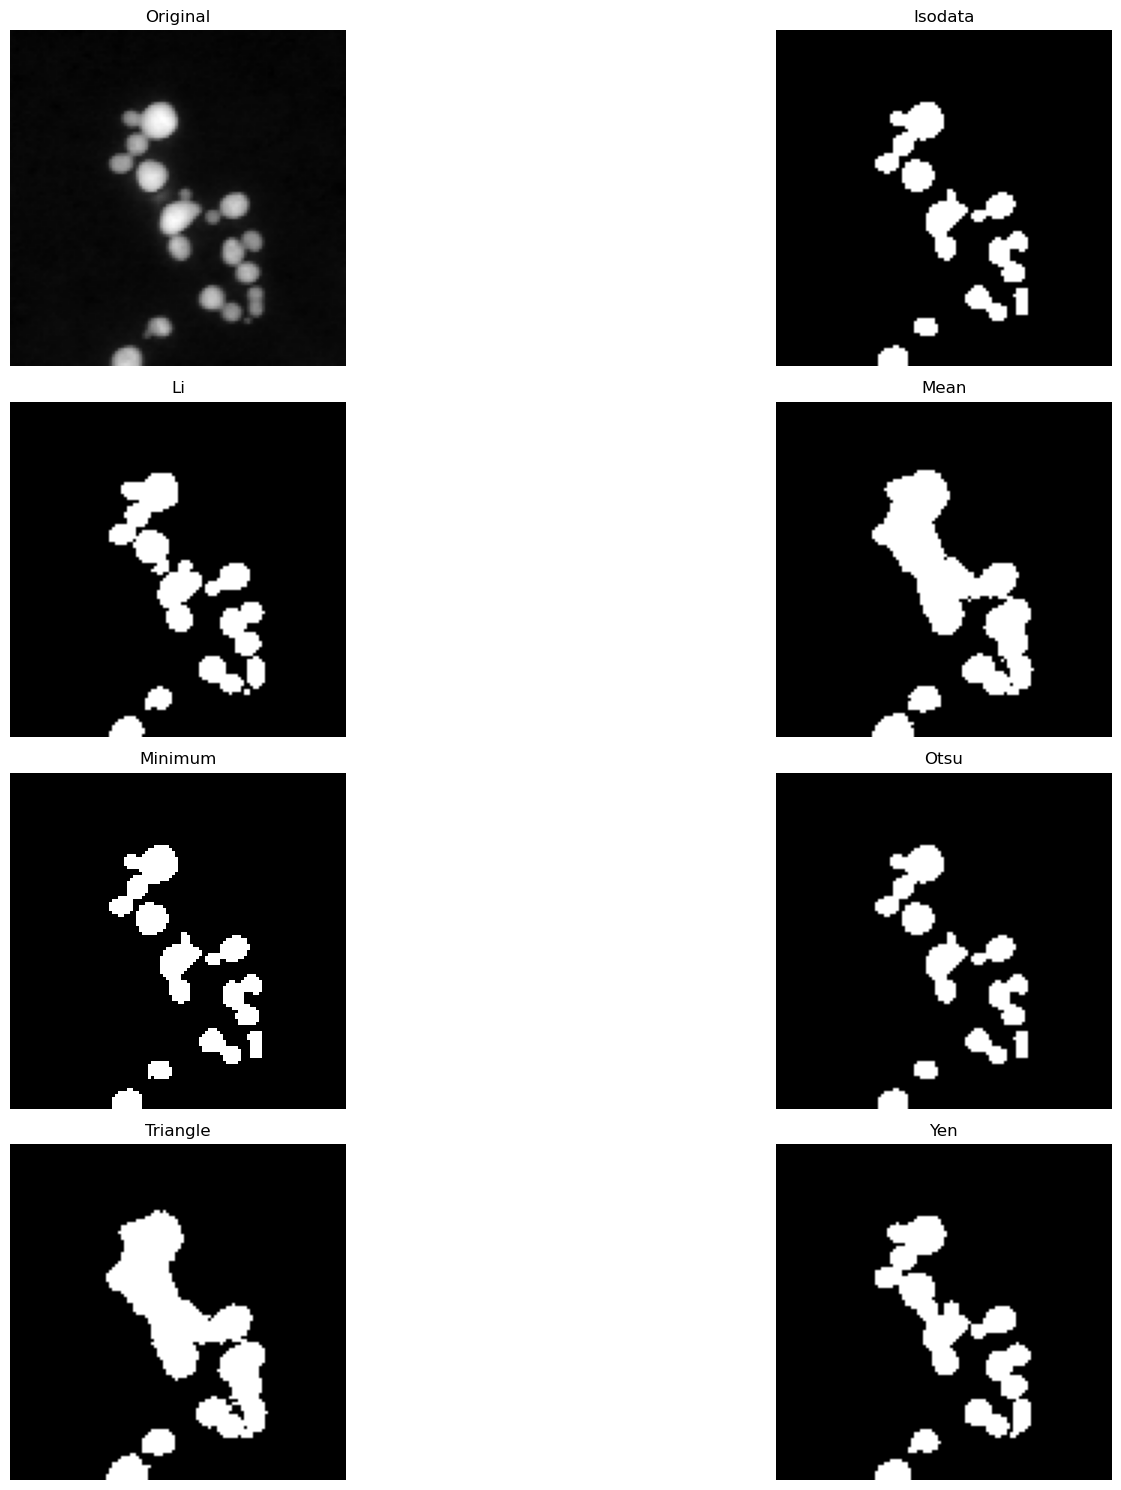

In [99]:
fig, ax = filters.try_all_threshold(image, figsize=(20, 15), verbose=False)

In this case, there are particles touching that we cannot separate via simple thresholding. It is possible to separate touching regions using a watershed algorithm, as shown below.

In [100]:
from skimage.filters import sobel
elevation_map = sobel(image)

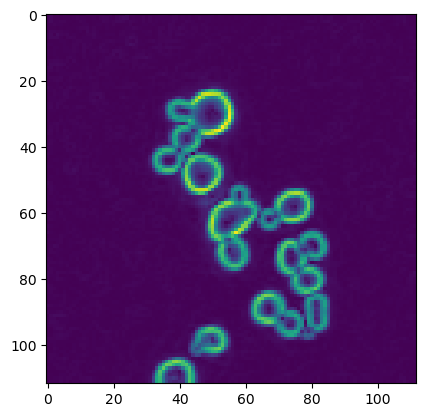

In [101]:
plt.imshow(elevation_map)

In [102]:
markers = np.zeros_like(image)
markers[image > 150] = 1
labels = measure.label(markers)
labels[labels>0] += 1
labels[image < 30] = 1

In [103]:
from skimage.segmentation import watershed
segmentation = watershed(elevation_map, labels)

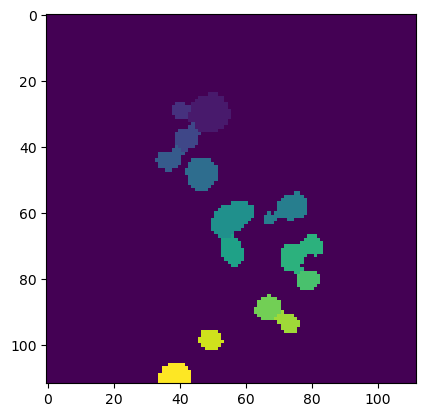

In [104]:
plt.imshow(segmentation)

In [24]:
print(labels.max())

16


In order to quantify segmented regions, scikit-image provides regionprops. The sort of information available in regionprops is shown below.

In [105]:
props = measure.regionprops(labels)

In [106]:
print(props)

[<skimage.measure._regionprops.RegionProperties object at 0x000002022C2492E0>, <skimage.measure._regionprops.RegionProperties object at 0x000002022C249A60>, <skimage.measure._regionprops.RegionProperties object at 0x000002022C216E80>, <skimage.measure._regionprops.RegionProperties object at 0x000002022C8C4130>, <skimage.measure._regionprops.RegionProperties object at 0x000002022C31DD90>, <skimage.measure._regionprops.RegionProperties object at 0x000002022C31DAF0>, <skimage.measure._regionprops.RegionProperties object at 0x000002022C395430>, <skimage.measure._regionprops.RegionProperties object at 0x000002022C2234F0>, <skimage.measure._regionprops.RegionProperties object at 0x000002022C223430>, <skimage.measure._regionprops.RegionProperties object at 0x000002022C595640>, <skimage.measure._regionprops.RegionProperties object at 0x000002022C5957C0>, <skimage.measure._regionprops.RegionProperties object at 0x000002022C595850>, <skimage.measure._regionprops.RegionProperties object at 0x0000

In [107]:
print(props[1].area)

103


In [108]:
calibrated_area = props[1].area * (1.2)**2

In [109]:
print(calibrated_area)

148.32


Properties can be plotted in a table using pandas.

In [110]:
# measure properties
import pandas as pd
props = measure.regionprops_table(labels, image, properties=['area', 'centroid', 'eccentricity','axis_major_length','axis_minor_length'])
props_df = pd.DataFrame(props)

props_df.head(5)

,area,centroid-0,centroid-1,eccentricity,axis_major_length,axis_minor_length
0,11160,54.422222,55.221237,0.233637,135.933296,132.171178
1,103,29.970874,48.990291,0.409908,11.984663,10.931532
2,3,29.333333,40.666667,0.816497,2.309401,1.333333
3,19,37.578947,42.105263,0.632281,5.544698,4.295695
4,13,44.153846,36.846154,0.699430,4.892662,3.496790


Let's look at an atomic resolution image.

In [179]:
image = plt.imread("HAADF_8MX_0055.tiff")

In [180]:
image.shape

(1024, 1024)

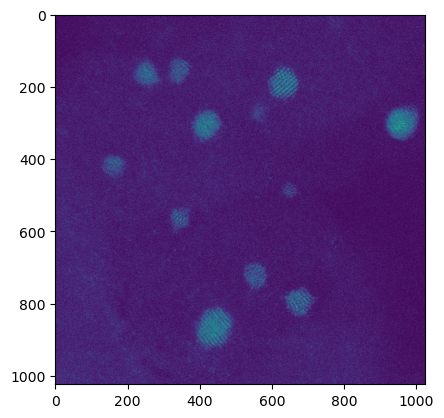

In [181]:
plt.imshow(image)

In [182]:
hist, hist_centers = histogram(image)

Text(0, 0.5, 'Number of pixels')

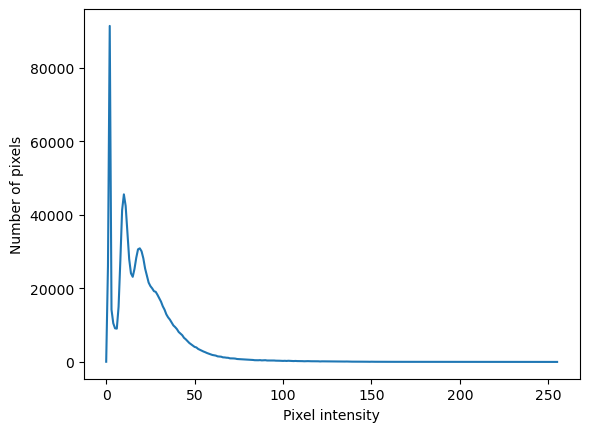

In [183]:
plt.figure()
plt.plot(hist)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')

In [184]:
thresh = filters.threshold_otsu(image)

In [185]:
print(thresh)

31


In [186]:
markers = np.zeros_like(image)
markers[image > thresh] = 1

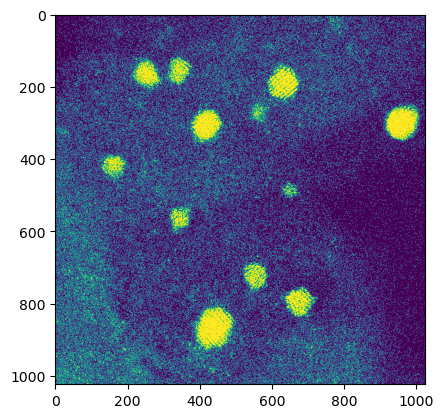

In [187]:
plt.imshow(markers)

You'll notice the Otsu Filter seperates out the lattice edges, and picks up some support due to the uneven background - that's not ideal for particle analysis. Let's use a Gaussian filter to segment each particle as a whole.

In [208]:
im_gauss = filters.gaussian(image, sigma=3)

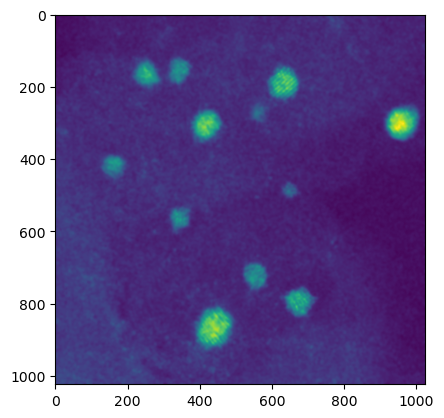

In [209]:
plt.imshow(im_gauss)

In [210]:
thresh = filters.threshold_otsu(im_gauss)

In [211]:
markers = np.zeros_like(im_gauss)
markers[im_gauss > thresh] = 1
print(thresh)

0.17906420348913019


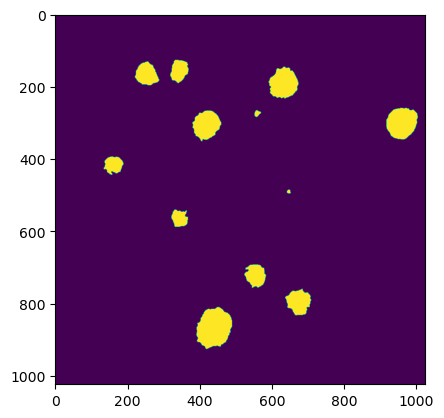

In [212]:
plt.imshow(im_gauss >= thresh)

As well as using filtering and segmentation, there have also been recent advancements in AI Segmentation. In particular, this version of the SAM (segment anything model) has been trained for TEM and STEM images : https://github.com/ArdaGen/STEM-Automated-Nanoparticle-Analysis-YOLOv8-SAM . 

Please read more there if you're interested in exploring that - there is an example notebook to work through!

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jul 28 16:11:43 2023

@author: ardag
"""
import cv2
from rsciio.digitalmicrograph import file_reader as dm_read
from rsciio.emd import file_reader as emd_read
from rsciio.tia import file_reader as tia_read
from rsciio.tiff import file_reader as tiff_read
import os

def load(path):
    _, extension = os.path.splitext(path)
    if extension.lower() in ('.dm3', '.dm4'):
        
        dm =  dm_read(path)
        pixel_size = round(dm[0]['original_metadata']["ImageList"]["TagGroup0"]["ImageData"]["Calibrations"]["Dimension"]["TagGroup0"]["Scale"],4)
        detector = dm[0]['original_metadata']["ImageList"]["TagGroup0"]["ImageTags"]["Microscope Info"]["Illumination Mode"]
        img = dm[0]["data"]
        img = (img/img.max())*255
        img = cv2.normalize(img, None, 0,255.0, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_x =cv2.bitwise_not(img)
        if detector == "TEM":
            img_x = img
        
    if extension.lower() in ('.tif', '.tiff'):
        
        tiff =  tiff_read(path)
        pixel_size =  round( float(tiff[0]['axes'][0]['scale'])*1e6, 3)
        img = tiff[0]["data"]
        img = (img/img.max())*255
        img = cv2.normalize(img, None, 0,255.0, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_x = img
        
    if extension.lower() == '.emd':
        emd = emd_read(path)
        pixel_size = round(float(emd[0]['original_metadata']["BinaryResult"]['PixelSize']["width"])*1e9,3)
        detector = emd[0]['original_metadata']['BinaryResult']['Detector']
        img = emd[0]["data"]
        img = cv2.normalize(img, None, 0,255.0, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_x = cv2.bitwise_not(img)
        if detector == 'BM-Ceta':
            img_x = img
        
    if extension.lower() == '.emi':
        tia = tia_read(path)
        pixel_size = round(tia[0]['original_metadata']['ser_header_parameters']['CalibrationDeltaX']*1e9, 3)
        img = tia[0]['data']
        img = (img/img.max())*255
        img = cv2.normalize(img, None, 0,255.0, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_x =cv2.bitwise_not(img)
    
    return img_x, img, pixel_size
def particle_analysis(masks, boxes, pixel_size,path_to_csv_file, save=False):
    Diameter = []
    Area = []
    pixel_size = pixel_size  #* pixel_scale 
    for i in range(len(boxes)):
      mask = masks[i,:,:]
      mask = clear_border(mask)
      properties = ['area']
      props = regionprops_table(mask, properties=properties)
      y = props['area']
      A = y*pixel_size*pixel_size
      Area.append(A)
      D = (np.sqrt(A/3.14))*2
      Diameter.append(D)
      
    
    Diameter = [i for i in Diameter if i > 0]
    Diameter = np.array(Diameter)
    Area = [i for i in Area if i > 0]
    Area = np.array(Area)
    print('Mean Diameter : ' + str(np.round(np.mean(Diameter),2)) +' nm')
    print('Mean Area : ' + str(np.round(np.mean(Area),2))+' nm\u00b2') 
    
    fig, axs = plt.subplots(1, 2, sharey = False, tight_layout = False, figsize=(5, 3))
    axs[0].hist(Diameter, bins = 30, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
    axs[0].set_title("Diameter")
    axs[0].set_xlabel('nm')
    axs[1].hist(Area, bins = 30, facecolor='red', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
    axs[1].set_title("Area")
    axs[1].set_xlabel('nm\u00b2')
    
    if save == True:
        Diameter= np.concatenate(Diameter)
        Area = np.concatenate(Area)
        dict = {'Diameter (nm)' : Diameter,'Area (nm2)' : Area}
        df = pd.DataFrame(dict)
        df.to_csv(path_to_csv_file)
    plt.show()
    return Diameter, Area

def object_detection (img_x, img, path_to_image, img_size=1024, pred_score = 0.25, overlap_thr =0.5, save = False, s_txt = False):
    from ultralytics import YOLO
    path_to_weights_obj = "best12x.pt" # Weights for the YOLO
    model = YOLO(path_to_weights_obj)
    model.to('cuda')
    # Run detection on the image
    results = model.predict(source = img_x, imgsz = img_size, conf = pred_score, max_det= 4000, iou = overlap_thr, save_txt = s_txt)
    
    # Get bounding boxes
    for result in results:
        boxes = result.boxes
     
    bbox = boxes.xyxy.tolist()
    #class_id=results[0].boxes.cls.cpu().numpy().astype(int)
    #points = [item[:2] for item in bbox]
    # Visualize bounding boxes
    res_plotted = results[0].plot(labels=False, line_width=2, img=img)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(res_plotted)
    if save == True:
        plt.savefig(path_to_image,bbox_inches='tight', pad_inches = 0)
    plt.show()
    #plot_bboxes(img, results[0].boxes.boxes, score=False)
    
    return bbox


def segmentation(img, bbox, erode = False, dilate = False, kernel_size =(5, 5) ):


    # Load the model
    sam_checkpoint = r"E:\Coding\SegmentAnythingModel\ArdaGen_STEM\sam_vit_b_01ec64.pth" # weights for the SAM path
    model_type = "vit_b"
    device = "cuda"
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    predictor = SamPredictor(sam)


    # Run model on the image
    predictor.set_image(img)


    input_boxes = torch.tensor(bbox, device=predictor.device)
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, img.shape[:2])
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    
    masks_array = masks.cpu().numpy().squeeze()
    masks3D_array = masks_array.astype('uint8')
    
    if erode == True:
        # Erode
        
        kernel = np.ones((kernel_size), np.uint8)
        masks3D_erode = []
        for mask in masks3D_array:
            mask = cv2.erode(mask, kernel)
            masks3D_erode.append(mask)
        masks3D_erode = np.asarray(masks3D_erode)
        masks3D_array = masks3D_erode 
        
    if dilate == True:
        # Erode
        
        kernel = np.ones((kernel_size), np.uint8)
        masks3D_erode = []
        for mask in masks3D_array:
            mask = cv2.dilate(mask, kernel)
            masks3D_erode.append(mask)
        masks3D_erode = np.asarray(masks3D_erode)
        masks3D_array = masks3D_erode 
    
    return masks3D_array


def segmentation_fast(img, bbox):


    from ultralytics import SAM
    model = SAM('mobile_sam.pt')
    device = "cpu"

    results = model.predict(img, bboxes=bbox, save=False, device=device)

    for result in results:
        mask = result.masks
    masks3D_array = mask.data
    masks3D_array = masks3D_array.cpu().numpy()
    masks3D_array= masks3D_array.astype('uint8')
    
    return masks3D_array

def show_mask(mask, ax, random_color=False, save = False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def visualize_mask (masks, img, path_to_imageseg, img_size = (256, 256), save = False):
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.resize(img, img_size))
    for mask in masks:
        show_mask(cv2.resize(mask, img_size), plt.gca(), random_color=True)
    plt.axis('off')
    if save == True:
        plt.savefig(path_to_imageseg, bbox_inches='tight', pad_inches = 0)
    plt.show()

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def velox_emd (path, adap = False):
    file = h5py.File(path,'r', rdcc_nbytes=10485760)

    list_data= list(file['Data/Image'].values())
    group = list_data[0]
    data = group['Data']
    tempmetadata = group['Metadata'][:, 0]
    validmetadataindex = np.where(tempmetadata > 0)
    metadata = tempmetadata[validmetadataindex].tobytes()
    metadata_json = json.loads(metadata.decode('utf-8','ignore'))
    pixel_size = round(float(metadata_json["BinaryResult"]["PixelSize"]["width"]) * 1e9, 3) 
    detector = metadata_json["BinaryResult"]["Detector"]
    data_squeezed = np.squeeze(data[:])
    
    if adap == True:
        data_squeezed = exposure.equalize_adapthist(data_squeezed, clip_limit=0.01)
        
  
    if detector == 'HAADF':
        data_squeezed_8bit = ((data_squeezed/np.max(data_squeezed))*255).astype('uint8')
        data_squeezed_inverted =cv2.bitwise_not(data_squeezed_8bit)
        magnification = metadata_json['CustomProperties']['StemMagnification']['value']
        scan_size = metadata_json['Scan']['ScanSize']['width']
        img_x = cv2.cvtColor(data_squeezed_inverted, cv2.COLOR_GRAY2RGB)
        img =  cv2.cvtColor(data_squeezed_8bit, cv2.COLOR_GRAY2RGB) 
        print ( 'Detector : ' + str(detector))
        print( 'Mag : ' + str(magnification))
        print( 'Scan size :' + str(scan_size))
        print( 'Pixel size (nm) : ' + str(pixel_size))
        

    else :
        data_squeezed_8bit = ((data_squeezed/np.max(data_squeezed))*255).astype('uint8')
        img = cv2.cvtColor(data_squeezed_8bit, cv2.COLOR_GRAY2RGB) 
        magnification = round( float(metadata_json['Optics']['NominalMagnification']), 1)
        frame_size = data_squeezed_8bit.shape[0]
        print ( 'Detector : ' + str(detector))
        print( 'Mag : ' + str(magnification))
        print ('Image size :' + str(frame_size))
        print( 'Pixel size (nm) : ' + str(pixel_size))
        img_x = img
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(img)
    return img_x, img, pixel_size

In [7]:
import particlespy as ps
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import pandas as pd
import cv2

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from segment_anything.utils import transforms
import torch
import sys
import h5py
import json

from skimage import exposure
from skimage.measure import regionprops,regionprops_table
from skimage.segmentation import clear_border
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

diameter_total = []
area_total = []

# Load S/TEM image in path_to_data (supported formats : ".emd", ".emi", ".dm3", ".dm4")
path_to_data = r"C:\Users\ellak\OneDrive - Cardiff University\phd\Conferences\MMC2025\WorkshopPrep\HAADF_2MX_0078.dm4"

# Get the S/TEM image and pixel size (please correct the pixel size if it is not avaiable in the metadata)
img_x, img, pixel_size = load(path_to_data)



0: 1024x1024 114 Particles, 70.8ms
Speed: 12.2ms preprocess, 70.8ms inference, 354.9ms postprocess per image at shape (1, 3, 1024, 1024)


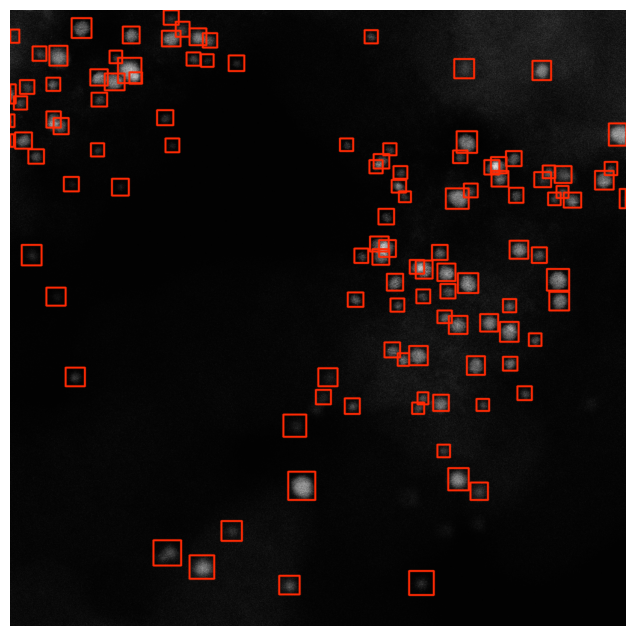

In [8]:
# Path to save bbox image
path_to_image = r''

# Get the bounding boxes:
boxes = object_detection(img_x, img, path_to_image, img_size = 1024, pred_score = 0.2, overlap_thr = 0.4, save = False)


In [9]:
masks = segmentation(img_x, boxes)

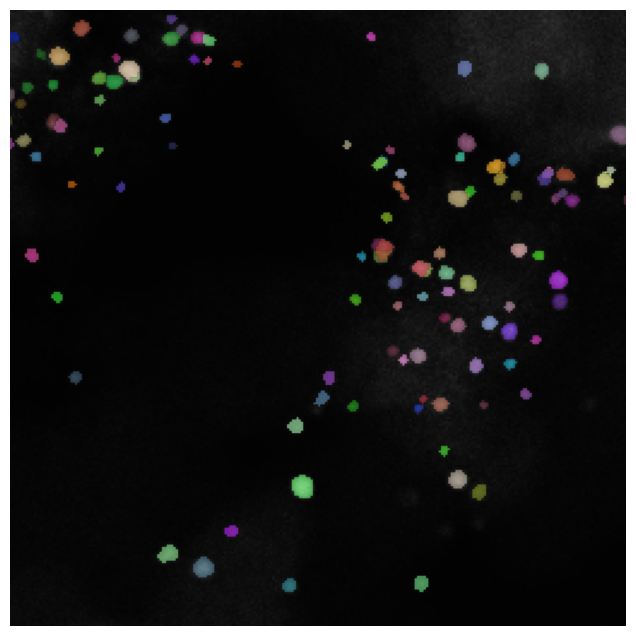

In [10]:
# Path to save the output segmented image
path_to_imageseg = r''

visualize_mask(masks, img, path_to_imageseg, img_size = (256, 256), save = False)

C:\Users\ellak\AppData\Local\Temp\ipykernel_19560\1550386997.py:76: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  Diameter = [i for i in Diameter if i > 0]
C:\Users\ellak\AppData\Local\Temp\ipykernel_19560\1550386997.py:78: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  Area = [i for i in Area if i > 0]


Mean Diameter : 2.11 nm
Mean Area : 3.74 nm²


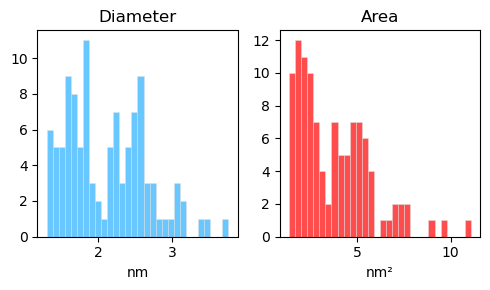

In [11]:
# Path to save the output csv file
path_to_csv_file = r''

# Histogram of particle diameter and area
diameter, area = particle_analysis(masks, boxes, pixel_size, path_to_csv_file, save = False)